In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

try:
    import xgboost as xgb
except:
    xgb = None

# --------------------------
# Load or generate dataset
# --------------------------
def load_dataset(path='car_data.csv'):
    if os.path.exists(path):
        return pd.read_csv(path)
    print("Generating synthetic dataset...")
    n = 2000
    rng = np.random.RandomState(42)
    
    year = rng.randint(2000, 2021, n)
    age = 2021 - year
    mileage = np.clip(rng.normal(50000, 20000, n), 500, None)
    brand = rng.choice(['Toyota','Honda','Ford','BMW','Audi'], n)
    engine = rng.choice([1200,1500,1800,2000,2500], n)
    horsepower = (engine*0.06 + rng.normal(0,5,n)).astype(int)
    fuel = rng.choice(['Petrol','Diesel','Hybrid'], n)

    base = 20000 + engine*5 + horsepower*50 - age*700 - mileage*0.05
    uplift = np.where(brand=='BMW',1.6, np.where(brand=='Audi',1.5,1.0))
    price = base*uplift + np.random.normal(0,3000,n)

    return pd.DataFrame({
        "Year": year,
        "Age": age,
        "Mileage": mileage,
        "Brand": brand,
        "EngineCC": engine,
        "Horsepower": horsepower,
        "FuelType": fuel,
        "Price": price
    })

df = load_dataset()
print(df.head())

# --------------------------
# Preprocessing
# --------------------------
target_col = "Price"
df = pd.get_dummies(df, drop_first=True)

numeric = df.select_dtypes(include=[np.number])
corr = numeric.corr()[target_col].abs().sort_values(ascending=False)
features = corr.index[1:9]
print("Selected features:", list(features))

X = numeric[features]
y = numeric[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# --------------------------
# Linear Regression
# --------------------------
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)

print("\nLinear Regression:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2:", r2_score(y_test, y_pred_lr))

# --------------------------
# Gradient Boosting
# --------------------------
gbr = GradientBoostingRegressor().fit(X_train_s, y_train)
y_pred_gbr = gbr.predict(X_test_s)

print("\nGradient Boosting:")
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("R2:", r2_score(y_test, y_pred_gbr))

# --------------------------
# XGBoost
# --------------------------
if xgb is not None:
    xgbr = xgb.XGBRegressor(n_estimators=200)
    xgbr.fit(X_train_s, y_train)
    y_pred_xgb = xgbr.predict(X_test_s)
    print("\nXGBoost:")
    print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
    print("R2:", r2_score(y_test, y_pred_xgb))
else:
    print("\nXGBoost not installed.")

# --------------------------
# OLS Regression + ANOVA
# --------------------------
df_ols = numeric[[target_col] + list(features)]
formula = target_col + " ~ " + " + ".join(features)
ols_model = smf.ols(formula, data=df_ols).fit()

print("\nOLS Summary:")
print(ols_model.summary())

anova = anova_lm(ols_model, typ=2)
print("\nANOVA Table:")
print(anova)

# --------------------------
# VIF
# --------------------------
X_vif = sm.add_constant(df_ols[features])
vif = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\nVIF:")
print(vif)

# --------------------------
# Save models
# --------------------------
os.makedirs("results", exist_ok=True)
joblib.dump(scaler, "results/scaler.joblib")
joblib.dump(lr, "results/linear_model.joblib")
joblib.dump(gbr, "results/gbr_model.joblib")

print("\nModels saved to results/")


Generating synthetic dataset...
   Year  Age       Mileage   Brand  EngineCC  Horsepower FuelType  \
0  2006   15  59439.226665   Honda      1200          68   Hybrid   
1  2019    2  52784.308173  Toyota      1200          77   Hybrid   
2  2014    7  74123.067913   Honda      1800         106   Petrol   
3  2010   11  57679.431051     BMW      1200          78   Hybrid   
4  2007   14  44321.163782     BMW      2500         155   Diesel   

          Price  
0  13955.831798  
1  19137.839114  
2  26846.090338  
3  27762.732423  
4  41587.749860  
Selected features: ['Age', 'Year', 'EngineCC', 'Horsepower', 'Mileage']

Linear Regression:
MAE: 6495.170199319902
RMSE: 7417.550356147022
R2: 0.4152476521740257

Gradient Boosting:
MAE: 6678.369148233221
RMSE: 7695.557706495721
R2: 0.3705935837225628

XGBoost:
MAE: 7721.142345203798
RMSE: 9385.475134669441
R2: 0.06381108521967649

OLS Summary:
                            OLS Regression Results                            
Dep. Variable:     

# Medium Pipeline: Clean ML + Ridge/Lasso/ElasticNet + RF + XGB (optional) + Safe VIF + Outliers + Poly + SHAP
# One Jupyter cell — run as is.

import os, time, warnings
warnings.filterwarnings("ignore")
os.makedirs("results", exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Optional heavy libs
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import shap
except Exception:
    shap = None

# ---------------- Helper funcs ----------------
def generate_synthetic(n=1500, seed=42):
    rng = np.random.RandomState(seed)
    year = rng.randint(2008, 2022, n)
    age = 2022 - year
    mileage = np.clip(rng.normal(55000, 25000, n), 100, None).astype(int)
    brand = rng.choice(['Toyota','Honda','Ford','BMW','Audi'], n, p=[0.3,0.25,0.25,0.1,0.1])
    engine = rng.choice([1000,1200,1500,1800,2000,2500], n)
    horsepower = (engine * 0.06 + rng.normal(0,8,n)).astype(int)
    fuel = rng.choice(['Petrol','Diesel','Hybrid'], n, p=[0.6,0.3,0.1])
    base = 12000 + engine*7 + horsepower*55 - age*700 - mileage*0.03
    uplift = np.where(brand=='BMW', 1.5, np.where(brand=='Audi',1.55,1.0))
    price = base * uplift + rng.normal(0,3000,n)
    return pd.DataFrame({
        'Year': year, 'Age': age, 'Mileage': mileage, 'Brand': brand,
        'EngineCC': engine, 'Horsepower': horsepower, 'FuelType': fuel, 'Price': price
    })

def detect_target(df):
    for c in df.columns:
        if 'price' in c.lower() or 'sale' in c.lower():
            return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[-1] if nums else df.columns[-1]

def remove_outliers(df, cols, method='iqr', isolation_frac=0.02):
    df2 = df.copy()
    if method == 'iqr':
        for c in cols:
            q1,q3 = df2[c].quantile(0.25), df2[c].quantile(0.75)
            iqr = q3-q1
            low, high = q1-1.5*iqr, q3+1.5*iqr
            df2 = df2[(df2[c]>=low) & (df2[c]<=high)]
    elif method == 'isolation':
        iso = IsolationForest(contamination=isolation_frac, random_state=42)
        mask = iso.fit_predict(df2[cols])==1
        df2 = df2[mask]
    return df2.reset_index(drop=True)

def compute_vif_safe(df, thresh=10.0, verbose=False):
    X = df.select_dtypes(include=[np.number]).copy()
    X = X.replace([np.inf,-np.inf], np.nan).dropna()
    if X.shape[1] == 0:
        return pd.DataFrame(columns=['feature','VIF']), X
    while True:
        if X.shape[1] <= 1:
            break
        Xc = sm.add_constant(X, has_constant='add')
        try:
            vifs = [variance_inflation_factor(Xc.values, i) for i in range(1, Xc.shape[1])]
        except Exception as e:
            print("VIF compute error:", e)
            break
        vif_df = pd.DataFrame({'feature': X.columns, 'VIF': vifs})
        max_vif = vif_df['VIF'].max()
        if verbose: print("max VIF:", max_vif)
        if max_vif > thresh:
            drop = vif_df.sort_values('VIF', ascending=False).iloc[0]['feature']
            if verbose: print("Dropping:", drop)
            X = X.drop(columns=[drop])
        else:
            break
    if X.shape[1] > 0:
        Xc = sm.add_constant(X, has_constant='add')
        vifs = [variance_inflation_factor(Xc.values, i) for i in range(1, Xc.shape[1])]
        vif_df = pd.DataFrame({'feature': X.columns, 'VIF': vifs})
    else:
        vif_df = pd.DataFrame(columns=['feature','VIF'])
    return vif_df.reset_index(drop=True), X.reset_index(drop=True)

def adjusted_r2(r2, n, p):
    return 1 - (1-r2)*(n-1)/(n-p-1) if (n-p-1)>0 else np.nan

# ---------------- Load data ----------------
DATA_PATH = "data/car_data.csv"
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print("Loaded", DATA_PATH)
else:
    print("No dataset found — generating synthetic data.")
    df = generate_synthetic()

print("Data preview:")
display(df.head())

target = detect_target(df)
print("Detected target:", target)

# ---------------- Feature engineering ----------------
if 'Age' not in df.columns and 'Year' in df.columns:
    df['Age'] = 2022 - df['Year']
if 'Mileage' in df.columns:
    df['high_mileage'] = (df['Mileage'] > df['Mileage'].median()).astype(int)
if {'EngineCC','Horsepower'}.issubset(df.columns):
    df['engine_hp_interaction'] = df['EngineCC'] * df['Horsepower']
if 'Age' in df.columns:
    df['age_bucket'] = pd.cut(df['Age'], bins=[-1,2,5,10,20,100], labels=['0-2','3-5','6-10','11-20','20+'])

df = df.dropna(subset=[target]).reset_index(drop=True)
print("After dropna, shape:", df.shape)

# ---------------- Outlier removal ----------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols: numeric_cols.remove(target)
print("Numeric cols:", numeric_cols[:15])

df_iqr = remove_outliers(df, cols=numeric_cols, method='iqr')
print("After IQR outlier removal:", df_iqr.shape)
df_iso = remove_outliers(df_iqr, cols=numeric_cols, method='isolation', isolation_frac=0.02)
print("After IsolationForest removal:", df_iso.shape)

work = df_iso.copy()

# ---------------- Split ----------------
X = work.drop(columns=[target])
y = work[target].astype(float)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train/test shapes:", X_train_raw.shape, X_test_raw.shape)

# ---------------- Preprocessing (train-only) ----------------
cat_cols = X_train_raw.select_dtypes(include=['object','category']).columns.tolist()
if 'age_bucket' in X_train_raw.columns and 'age_bucket' not in cat_cols:
    cat_cols.append('age_bucket')
num_cols = [c for c in X_train_raw.select_dtypes(include=[np.number]).columns.tolist() if c not in cat_cols]

print("Num cols:", num_cols)
print("Cat cols:", cat_cols)

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scale', StandardScaler())
])
X_train_num = pd.DataFrame(num_pipeline.fit_transform(X_train_raw[num_cols]), columns=num_cols, index=X_train_raw.index)
X_test_num = pd.DataFrame(num_pipeline.transform(X_test_raw[num_cols]), columns=num_cols, index=X_test_raw.index)

X_train_cat = pd.get_dummies(X_train_raw[cat_cols].astype(str), drop_first=True)
X_test_cat = pd.get_dummies(X_test_raw[cat_cols].astype(str), drop_first=True)
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)

X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print("Processed shapes:", X_train_proc.shape, X_test_proc.shape)

# ---------------- VIF safe fix ----------------
vif_df, X_train_vif = compute_vif_safe(X_train_proc, thresh=10.0, verbose=False)
print("VIF (top rows):")
print(vif_df.head().to_string(index=False))
X_test_vif = X_test_proc[X_train_vif.columns].copy()

# ---------------- Feature selection (top-correlated) ----------------
joined = pd.concat([X_train_vif.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
corrs = joined.corr()[target].abs().sort_values(ascending=False)
top_k = min(12, len(corrs)-1)
selected_feats = [f for f in corrs.index if f != target][:top_k]
print("Selected features:", selected_feats)

X_train_sel = X_train_vif[selected_feats].reset_index(drop=True)
X_test_sel = X_test_vif[selected_feats].reset_index(drop=True)

# ---------------- Polynomial features (optional) ----------------
do_poly = True
if do_poly:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_sel = pd.DataFrame(poly.fit_transform(X_train_sel), columns=poly.get_feature_names_out(selected_feats))
    X_test_sel = pd.DataFrame(poly.transform(X_test_sel), columns=poly.get_feature_names_out(selected_feats))
    print("Poly features:", X_train_sel.shape[1])
else:
    poly = None

# ---------------- Models & tuning ----------------
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RF': RandomForestRegressor(random_state=42)
}
if xgb is not None:
    models['XGB'] = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_spaces = {
    'Ridge': {'alpha': np.logspace(-3,3,20)},
    'Lasso': {'alpha': np.logspace(-4,2,20)},
    'ElasticNet': {'alpha': np.logspace(-4,2,20), 'l1_ratio': np.linspace(0,1,8)},
    'RF': {'n_estimators':[100,200], 'max_depth':[None,5,10]},
}
if xgb is not None:
    param_spaces['XGB'] = {'n_estimators':[100,200], 'max_depth':[3,5,7], 'learning_rate':[0.01,0.05,0.1]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)
results = []
trained = {}
fit_times = {}

for name, est in models.items():
    print(f"\nTraining {name} ...")
    t0 = time.time()
    if name in param_spaces:
        try:
            rs = RandomizedSearchCV(est, param_spaces[name], n_iter=6, cv=cv,
                                    scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
            rs.fit(X_train_sel, y_train)
            best = rs.best_estimator_
            trained[name] = best
            print("Best params:", rs.best_params_)
        except Exception as e:
            print("Tuning failed, fitting default:", e)
            est.fit(X_train_sel, y_train)
            trained[name] = est
    else:
        try:
            est.fit(X_train_sel, y_train)
            trained[name] = est
        except Exception as e:
            print("Fit failed:", e)
            trained[name] = est
    t1 = time.time()
    fit_times[name] = t1 - t0

    # predict & metrics (safe)
    try:
        y_pred = trained[name].predict(X_test_sel)
    except Exception as e:
        print("Predict error:", e)
        y_pred = np.zeros(len(y_test))
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # safe
    r2 = r2_score(y_test, y_pred)
    adj = adjusted_r2(r2, n=len(y_test), p=X_test_sel.shape[1])
    results.append({'model':name, 'MAE':mae, 'RMSE':rmse, 'R2':r2, 'AdjR2':adj, 'train_time_sec':fit_times[name]})
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}, AdjR2={adj:.4f}")

results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
results_df.to_csv("results/model_comparison.csv", index=False)
print("\nModel comparison saved -> results/model_comparison.csv")
display(results_df)

# ---------------- choose best ----------------
best_name = results_df.iloc[0]['model']
final_model = trained[best_name]
print("Selected final model:", best_name)

# ---------------- save pipeline artifact ----------------
artifact = {
    'num_pipeline': num_pipeline,
    'poly': poly,
    'final_model': final_model,
    'feature_columns': list(X_train_sel.columns),
    'selected_base_feats': selected_feats
}
joblib.dump(artifact, "results/pipeline.joblib")
print("Saved pipeline -> results/pipeline.joblib")

# save individual models
for n,m in trained.items():
    try:
        joblib.dump(m, f"results/model_{n}.joblib")
    except Exception as e:
        print("Could not save", n, e)

# ---------------- SHAP (optional) ----------------
if shap is not None:
    try:
        print("Computing SHAP for final model (may take time)...")
        bg = X_train_sel.sample(n=min(100, X_train_sel.shape[0]), random_state=42)
        if best_name in ['XGB'] and xgb is not None:
            expl = shap.TreeExplainer(final_model)
            sv = expl.shap_values(X_test_sel)
        elif best_name in ['RF']:
            expl = shap.TreeExplainer(final_model)
            sv = expl.shap_values(X_test_sel)
        else:
            expl = shap.LinearExplainer(final_model, bg, feature_perturbation="interventional")
            sv = expl.shap_values(X_test_sel)
        plt.figure(figsize=(8,6))
        shap.summary_plot(sv, X_test_sel, show=False)
        plt.tight_layout()
        plt.savefig(f"results/shap_summary_{best_name}.png", dpi=150)
        plt.close()
        print("Saved SHAP -> results/shap_summary_{}.png".format(best_name))
    except Exception as e:
        print("SHAP failed:", e)
else:
    print("SHAP not installed — skipped.")

# ---------------- Feature importance / coeffs ----------------
os.makedirs("results/feature_importance", exist_ok=True)
try:
    if hasattr(final_model, 'feature_importances_'):
        imp = final_model.feature_importances_
        fi = pd.DataFrame({'feature': X_train_sel.columns, 'importance': imp}).sort_values('importance', ascending=False)
        plt.figure(figsize=(8,6)); sns.barplot(data=fi.head(20), x='importance', y='feature'); plt.tight_layout()
        plt.savefig(f"results/feature_importance/fi_{best_name}.png", dpi=150); plt.close()
        print("Saved feature importance.")
    elif hasattr(final_model, 'coef_'):
        coeffs = pd.Series(final_model.coef_, index=X_train_sel.columns).sort_values(key=abs, ascending=False)
        coeffs.head(30).to_csv(f"results/feature_importance/coeffs_{best_name}.csv")
        plt.figure(figsize=(8,6)); coeffs.head(20).plot(kind='barh'); plt.tight_layout()
        plt.savefig(f"results/feature_importance/coeffs_{best_name}.png", dpi=150); plt.close()
        print("Saved coefficients.")
except Exception as e:
    print("Feature importance save error:", e)

# ---------------- Residual diagnostics ----------------
y_pred_final = final_model.predict(X_test_sel)
resid = y_test.values - y_pred_final
fitted = y_pred_final

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.scatter(fitted, resid, alpha=0.6); plt.axhline(0, color='red', linestyle='--'); plt.xlabel('Fitted'); plt.ylabel('Residuals'); plt.title('Residuals vs Fitted')
plt.subplot(1,3,2); sm.qqplot(resid, line='s', ax=plt.gca()); plt.title('QQ plot')
plt.subplot(1,3,3); plt.scatter(np.sqrt(np.abs(fitted)), resid, alpha=0.6); plt.xlabel('Sqrt(|Fitted|)'); plt.title('Scale-Location')
plt.tight_layout(); plt.savefig("results/residual_diagnostics.png", dpi=150); plt.close()
print("Saved residual diagnostics -> results/residual_diagnostics.png")

# ---------------- OLS interpretability (subset features) ----------------
try:
    ols_df = pd.concat([X_train_sel.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    ols_feats = list(X_train_sel.columns[:min(10, X_train_sel.shape[1])])
    formula = f"{target} ~ " + " + ".join([f"`{c}`" for c in ols_feats])
    ols_model = smf.ols(formula=formula, data=ols_df).fit()
    print(ols_model.summary())
    anova_tbl = anova_lm(ols_model, typ=2)
    anova_tbl.to_csv("results/ols_anova_interpret.csv")
    print("Saved OLS ANOVA -> results/ols_anova_interpret.csv")
except Exception as e:
    print("OLS interpret skipped:", e)

# ---------------- Save model comparison ----------------
results_df.to_csv("results/model_comparison.csv", index=False)
print("Saved model_comparison.csv and pipeline joblib. Pipeline ready for Streamlit app.")

print("\n=== FINISHED ===")
print("Best model:", best_name)
display(results_df)


**No local CSV found. Generated synthetic dataset — quick preview below.**

,Year,Age,Mileage,Brand,EngineCC,Horsepower,FuelType,Price
0,2014,8,119248,Toyota,1200,70,Petrol,22396.225167
1,2011,11,27322,BMW,1000,63,Petrol,22229.390339
2,2020,2,89714,Honda,1000,59,Diesel,18429.745412
3,2018,4,100,Honda,1200,74,Petrol,23095.721060
4,2015,7,3040,Honda,1200,86,Petrol,27728.583248


**Detected target column:** `Price`

**Dataset shape & dtypes**

(1500, 8)


Year            int32
Age             int32
Mileage         int64
Brand          object
EngineCC        int64
Horsepower      int64
FuelType       object
Price         float64
dtype: object

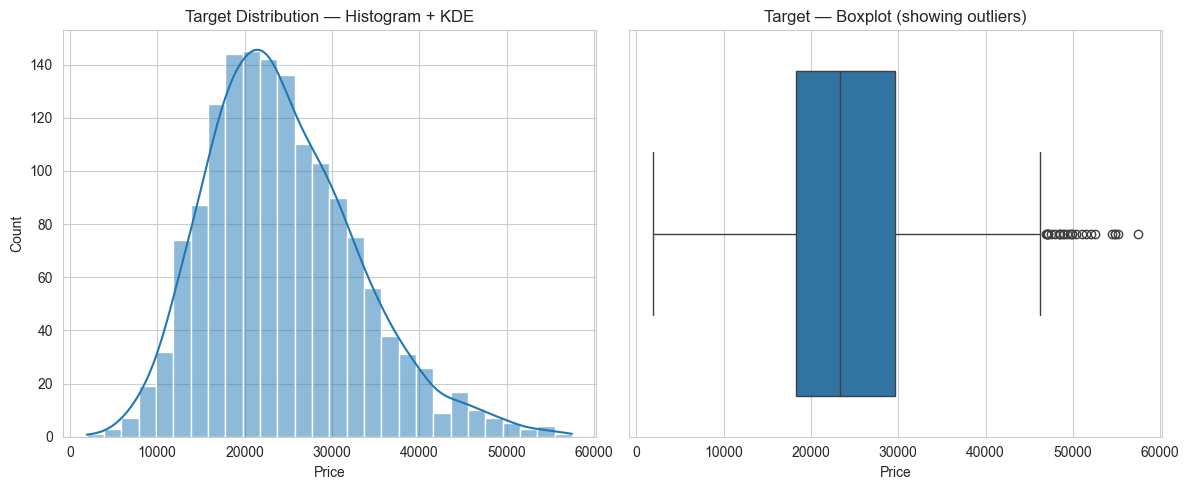

Saved descriptive statistics → `results/00_descriptive_statistics.csv`

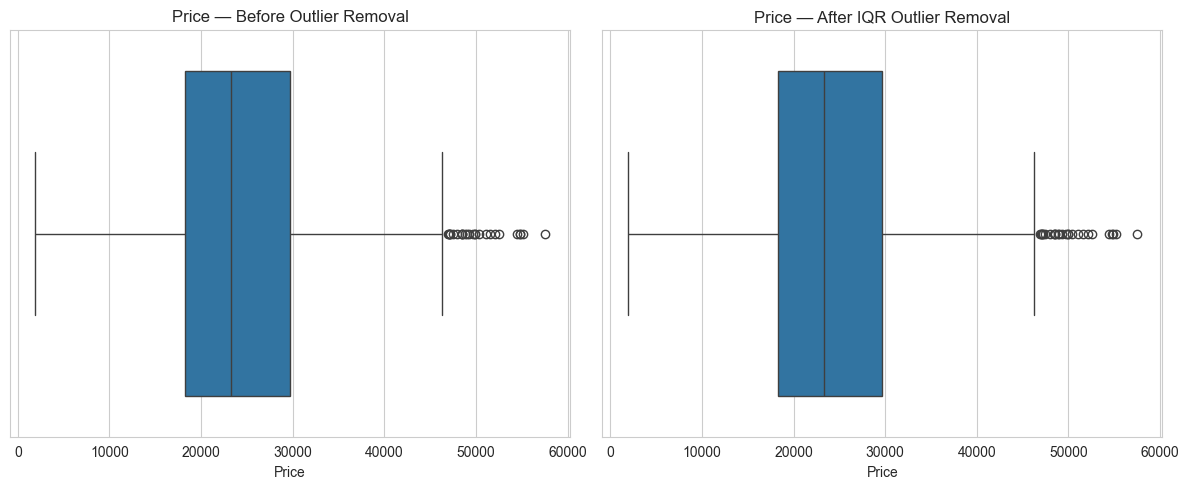

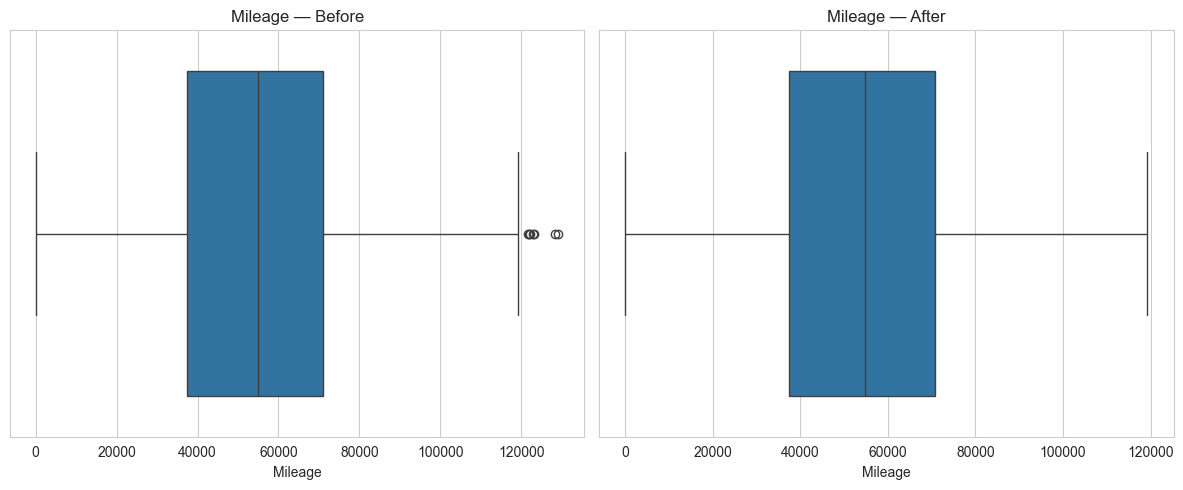

**After simple IQR filtering:** original shape (1500, 8) → filtered shape (1493, 8)

ValueError: could not convert string to float: 'Toyota'

In [6]:
# %% [markdown]
# # Car Price Prediction — Part 1/3
# **EDA & Visual Storytelling**  
# This notebook cell loads (or synthesizes) data and produces rich EDA visualizations:
# - Data preview & summary
# - Target distribution (hist + box)
# - Before / After outlier comparison
# - Correlation heatmap & VIF overview
# - Pairplot (scatter matrix) of key features
# - Feature distributions & categorical counts
# All outputs (plots / tables) are saved under `results/` so Part-2 can reuse them.

# %%
# Part 1 — Imports and helpers
import os, warnings, textwrap
warnings.filterwarnings("ignore")
os.makedirs("results", exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

from IPython.display import display, Markdown

# Stats / modeling helpers used just for diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Optional heavy libs — if missing, code still runs
try:
    import pandas_profiling
    HAVE_PROFILE = True
except Exception:
    HAVE_PROFILE = False

# %%
# Part 1 — Data load (auto) with clear messaging
DATA_PATH = "data/car_data.csv"

def generate_synthetic(n=1500, seed=42):
    rng = np.random.RandomState(seed)
    year = rng.randint(2008, 2022, n)
    age = 2022 - year
    mileage = np.clip(rng.normal(55000, 25000, n), 100, None).astype(int)
    brand = rng.choice(['Toyota','Honda','Ford','BMW','Audi'], n, p=[0.3,0.25,0.25,0.1,0.1])
    engine = rng.choice([1000,1200,1500,1800,2000,2500], n)
    horsepower = (engine * 0.06 + rng.normal(0,8,n)).astype(int)
    fuel = rng.choice(['Petrol','Diesel','Hybrid'], n, p=[0.6,0.3,0.1])
    base = 12000 + engine*7 + horsepower*55 - age*700 - mileage*0.03
    uplift = np.where(brand=='BMW', 1.5, np.where(brand=='Audi',1.55,1.0))
    price = base * uplift + rng.normal(0,3000,n)
    return pd.DataFrame({
        'Year': year, 'Age': age, 'Mileage': mileage, 'Brand': brand,
        'EngineCC': engine, 'Horsepower': horsepower, 'FuelType': fuel, 'Price': price
    })

if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    display(Markdown(f"**Loaded dataset from `{DATA_PATH}`** — shape: {df.shape}"))
else:
    df = generate_synthetic()
    display(Markdown("**No local CSV found. Generated synthetic dataset — quick preview below.**"))

# show top rows
display(df.head())

# detect target automatically
def detect_target(df):
    for c in df.columns:
        if 'price' in c.lower() or 'sale' in c.lower():
            return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[-1] if nums else df.columns[-1]

target = detect_target(df)
display(Markdown(f"**Detected target column:** `{target}`"))

# Quick shape + dtypes
display(Markdown("**Dataset shape & dtypes**"))
print(df.shape)
display(df.dtypes)

# %% [markdown]
# ## 1) Target Distribution (Histogram + Boxplot)
# Visualize price distribution and save figure.

# %%
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df[target], kde=True)
plt.title("Target Distribution — Histogram + KDE")
plt.xlabel(target)

plt.subplot(1,2,2)
sns.boxplot(x=df[target])
plt.title("Target — Boxplot (showing outliers)")
plt.tight_layout()
plt.savefig("results/00_target_distribution.png", dpi=150)
plt.show()

# Save basic descriptive stats
desc = df.describe(include='all').T
desc.to_csv("results/00_descriptive_statistics.csv")
display(Markdown("Saved descriptive statistics → `results/00_descriptive_statistics.csv`"))

# %% [markdown]
# ## 2) Outlier detection (visual) — Before & After
# We'll apply IQR-based removal for visualization and show side-by-side boxplots.

# %%
# numeric columns for outlier scan
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

# IQR removal (simple)
def iqr_filter(df, cols):
    out = df.copy()
    for c in cols:
        q1 = out[c].quantile(0.25)
        q3 = out[c].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5*iqr
        high = q3 + 1.5*iqr
        out = out[(out[c] >= low) & (out[c] <= high)]
    return out.reset_index(drop=True)

df_iqr = iqr_filter(df, numeric_cols)

# Plot before vs after for Price
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=df[target])
plt.title("Price — Before Outlier Removal")

plt.subplot(1,2,2)
sns.boxplot(x=df_iqr[target])
plt.title("Price — After IQR Outlier Removal")
plt.tight_layout()
plt.savefig("results/01_outlier_before_after_price.png", dpi=150)
plt.show()

# Also compare Mileage
if 'Mileage' in df.columns:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.boxplot(x=df['Mileage'])
    plt.title("Mileage — Before")
    plt.subplot(1,2,2)
    sns.boxplot(x=df_iqr['Mileage'])
    plt.title("Mileage — After")
    plt.tight_layout()
    plt.savefig("results/01_outlier_before_after_mileage.png", dpi=150)
    plt.show()

display(Markdown(f"**After simple IQR filtering:** original shape {df.shape} → filtered shape {df_iqr.shape}"))

# %% [markdown]
# ## 3) Correlation Matrix & Heatmap
# Show correlation among numeric features (after outlier removal), save figure.

# %%
corr = df_iqr.corr()
plt.figure(figsize=(11,9))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Correlation Heatmap (IQR-filtered data)")
plt.tight_layout()
plt.savefig("results/02_corr_heatmap.png", dpi=150)
plt.show()

# Save numeric correlation to csv (useful later)
corr.to_csv("results/02_corr_matrix.csv")
display(Markdown("Saved correlation matrix → `results/02_corr_matrix.csv`"))

# %% [markdown]
# ## 4) Pairplot (Scatter matrix) for key features
# A compact pairplot to inspect relationships. We'll select a small set of useful columns that exist.

# %%
pair_cols = [c for c in ['Age','Mileage','EngineCC','Horsepower', target] if c in df_iqr.columns]
if len(pair_cols) >= 2:
    sns.pairplot(df_iqr[pair_cols], diag_kind="kde", plot_kws={'s':15, 'alpha':0.6})
    plt.suptitle("Pairplot — key numeric relationships", y=1.02)
    plt.savefig("results/03_pairplot.png", dpi=150)
    plt.show()
else:
    display(Markdown("Not enough numeric columns for pairplot."))

# %% [markdown]
# ## 5) Categorical counts & boxplots
# Visualize counts for Brand & FuelType (if present) and boxplots of Price by category.

# %%
cat_cols = [c for c in ['Brand','FuelType','age_bucket'] if c in df_iqr.columns]
for c in cat_cols:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.countplot(y=df_iqr[c], order=df_iqr[c].value_counts().index)
    plt.title(f"Counts — {c}")
    plt.subplot(1,2,2)
    sns.boxplot(x=target, y=c, data=df_iqr)
    plt.title(f"{target} by {c}")
    plt.tight_layout()
    plt.savefig(f"results/04_cat_{c}_counts_box.png", dpi=150)
    plt.show()

# %% [markdown]
# ## 6) VIF check (quick) — show high VIF candidates (on numeric features only)
# We'll compute VIF safely (drop non-numeric and NaNs) and save a table + barplot.

# %%
def compute_vif_quick(df_numeric):
    X = df_numeric.select_dtypes(include=[np.number]).copy()
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    if X.shape[1] == 0:
        return pd.DataFrame(columns=['feature','VIF'])
    Xc = sm.add_constant(X, has_constant='add')
    vifs = []
    for i in range(1, Xc.shape[1]):
        try:
            v = variance_inflation_factor(Xc.values, i)
        except Exception:
            v = np.nan
        vifs.append(v)
    vif_df = pd.DataFrame({'feature': X.columns, 'VIF': vifs}).sort_values('VIF', ascending=False)
    return vif_df

vif_df = compute_vif_quick(df_iqr[numeric_cols]) if len(numeric_cols)>0 else pd.DataFrame()
if not vif_df.empty:
    vif_df.to_csv("results/05_vif_quick.csv", index=False)
    display(Markdown("Saved quick VIF -> `results/05_vif_quick.csv`"))
    plt.figure(figsize=(8,6))
    sns.barplot(data=vif_df.head(20), x='VIF', y='feature', palette='coolwarm')
    plt.title("VIF quick check (highest first)")
    plt.tight_layout()
    plt.savefig("results/05_vif_quick.png", dpi=150)
    plt.show()
else:
    display(Markdown("VIF: no numeric features found or insufficient data."))

# %% [markdown]
# ## 7) Target skewness & transformation hint
# Print skewness/kurtosis and show log-transform suggestion plot.

# %%
from scipy import stats
skewness = stats.skew(df_iqr[target].dropna())
kurtosis = stats.kurtosis(df_iqr[target].dropna())
display(Markdown(f"**Skewness:** {skewness:.3f} — **Kurtosis:** {kurtosis:.3f}"))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(df_iqr[target], kde=True)
plt.title("Original")

plt.subplot(1,3,2)
sns.histplot(np.log1p(df_iqr[target]), kde=True)
plt.title("Log1p Transformed")

plt.subplot(1,3,3)
sns.boxplot(x=np.log1p(df_iqr[target]))
plt.title("Log1p Boxplot")
plt.tight_layout()
plt.savefig("results/06_target_transform_suggestion.png", dpi=150)
plt.show()

# %% [markdown]
# ## 8) Save cleaned snapshot for Part-2
# We'll save the IQR filtered dataset as `results/cleaned_data.csv` for the ML pipeline to use.
# (Part-2 will prefer `results/cleaned_data.csv` if exists; otherwise it will use original df)

# %%
df_iqr.to_csv("results/cleaned_data.csv", index=False)
display(Markdown("Saved cleaned snapshot for modeling → `results/cleaned_data.csv`"))

# %% [markdown]
# ### End of Part 1 — EDA & Visual Storytelling
# Plots and tables saved to `results/`.  
# Next: Part-2 will run the ML pipeline (VIF-safe feature selection, polynomial features, tuning, models, and model comparison dashboard).
#
# Run Part-2 next (I'll provide it as the next code block).
# %% [markdown]
# # Car Price Prediction — Part 2/3
# **ML pipeline, safe-VIF feature selection, training, tuning, and model comparison dashboard**
# (Run this cell after Part 1)

# %%
# Part 2 — Imports + helpers
import os, time, warnings
warnings.filterwarnings("ignore")
os.makedirs("results", exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# optional
try:
    import xgboost as xgb
except Exception:
    xgb = None

# ---------------- Load cleaned data (prefer Part-1 output) ----------------
CLEAN_PATH = "results/cleaned_data.csv"
SRC_PATH = "data/car_data.csv"

if os.path.exists(CLEAN_PATH):
    df = pd.read_csv(CLEAN_PATH)
    print("Loaded cleaned dataset from results/cleaned_data.csv")
elif os.path.exists(SRC_PATH):
    df = pd.read_csv(SRC_PATH)
    print("Loaded dataset from data/car_data.csv")
else:
    # fallback synthetic (same generator as Part1)
    print("No CSV found — generating synthetic dataset.")
    rng = np.random.RandomState(42)
    n = 1500
    year = rng.randint(2008, 2022, n); age = 2022 - year
    mileage = np.clip(rng.normal(55000,25000,n),100,None).astype(int)
    brand = rng.choice(['Toyota','Honda','Ford','BMW','Audi'], n, p=[0.3,0.25,0.25,0.1,0.1])
    engine = rng.choice([1000,1200,1500,1800,2000,2500], n)
    horsepower = (engine*0.06 + rng.normal(0,8,n)).astype(int)
    fuel = rng.choice(['Petrol','Diesel','Hybrid'], n, p=[0.6,0.3,0.1])
    base = 12000 + engine*7 + horsepower*55 - age*700 - mileage*0.03
    uplift = np.where(brand=='BMW',1.5,np.where(brand=='Audi',1.55,1.0))
    price = base * uplift + rng.normal(0,3000,n)
    df = pd.DataFrame({'Year':year,'Age':age,'Mileage':mileage,'Brand':brand,'EngineCC':engine,'Horsepower':horsepower,'FuelType':fuel,'Price':price})
    print("Synthetic dataset created")

display(df.head())

# ---------------- detect target + ensure numeric ----------------
def detect_target(df):
    for c in df.columns:
        if 'price' in c.lower() or 'sale' in c.lower():
            return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[-1] if nums else df.columns[-1]

target = detect_target(df)
print("Target:", target)

# drop rows with missing target
df = df.dropna(subset=[target]).reset_index(drop=True)

# ---------------- Basic FE (if not present) ----------------
if 'Age' not in df.columns and 'Year' in df.columns:
    df['Age'] = 2022 - df['Year']
if 'high_mileage' not in df.columns and 'Mileage' in df.columns:
    df['high_mileage'] = (df['Mileage'] > df['Mileage'].median()).astype(int)
if {'EngineCC','Horsepower'}.issubset(df.columns) and 'engine_hp_interaction' not in df.columns:
    df['engine_hp_interaction'] = df['EngineCC'] * df['Horsepower']
if 'age_bucket' not in df.columns and 'Age' in df.columns:
    df['age_bucket'] = pd.cut(df['Age'], bins=[-1,2,5,10,20,100], labels=['0-2','3-5','6-10','11-20','20+'])

# ---------------- Outlier removal (optional already applied in Part1) ----------------
# We'll not re-run heavy filters here; Part1 already saved cleaned_data.csv. Use df as is.

# ---------------- Train/Test split ----------------
X = df.drop(columns=[target])
y = df[target].astype(float)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train/test shapes:", X_train_raw.shape, X_test_raw.shape)

# ---------------- Preprocessing pipelines (fit on train only) ----------------
# categorical columns
cat_cols = X_train_raw.select_dtypes(include=['object','category']).columns.tolist()
if 'age_bucket' in X_train_raw.columns and 'age_bucket' not in cat_cols:
    cat_cols.append('age_bucket')

num_cols = [c for c in X_train_raw.select_dtypes(include=[np.number]).columns.tolist() if c not in cat_cols]
print("Numeric cols:", num_cols[:20])
print("Categorical cols:", cat_cols)

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scale', StandardScaler())
])
# fit numeric pipeline
X_train_num = pd.DataFrame(num_pipeline.fit_transform(X_train_raw[num_cols]), columns=num_cols, index=X_train_raw.index)
X_test_num = pd.DataFrame(num_pipeline.transform(X_test_raw[num_cols]), columns=num_cols, index=X_test_raw.index)

# categorical encoding (train-only dummies)
X_train_cat = pd.get_dummies(X_train_raw[cat_cols].astype(str), drop_first=True)
X_test_cat = pd.get_dummies(X_test_raw[cat_cols].astype(str), drop_first=True)
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)

# combine
X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)
print("Processed shapes:", X_train_proc.shape, X_test_proc.shape)

# ---------------- VIF safe removal ----------------
def compute_vif_safe(df, thresh=10.0, verbose=False):
    X = df.select_dtypes(include=[np.number]).copy()
    X = X.replace([np.inf,-np.inf], np.nan).dropna()
    if X.shape[1] == 0:
        return pd.DataFrame(columns=['feature','VIF']), X
    while True:
        if X.shape[1] <= 1:
            break
        Xc = sm.add_constant(X, has_constant='add')
        try:
            vifs = [variance_inflation_factor(Xc.values, i) for i in range(1, Xc.shape[1])]
        except Exception as e:
            print("VIF compute error:", e)
            break
        vif_df = pd.DataFrame({'feature': X.columns, 'VIF': vifs})
        max_vif = vif_df['VIF'].max()
        if verbose: print("max VIF:", max_vif)
        if max_vif > thresh:
            drop = vif_df.sort_values('VIF', ascending=False).iloc[0]['feature']
            if verbose: print("Dropping:", drop)
            X = X.drop(columns=[drop])
        else:
            break
    if X.shape[1] > 0:
        Xc = sm.add_constant(X, has_constant='add')
        vifs = [variance_inflation_factor(Xc.values, i) for i in range(1, Xc.shape[1])]
        vif_df = pd.DataFrame({'feature': X.columns, 'VIF': vifs})
    else:
        vif_df = pd.DataFrame(columns=['feature','VIF'])
    return vif_df.reset_index(drop=True), X.reset_index(drop=True)

print("Computing VIF and auto-dropping...")
vif_df, X_train_vif = compute_vif_safe(X_train_proc, thresh=10.0, verbose=False)
print("VIF top rows:")
display(vif_df.head())
# align test
X_test_vif = X_test_proc[X_train_vif.columns].copy()

# save vif table
vif_df.to_csv("results/vif_after_auto_drop.csv", index=False)

# ---------------- feature selection by correlation (train) ----------------
joined = pd.concat([X_train_vif.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
corr_with_target = joined.corr()[target].abs().sort_values(ascending=False)
# pick top_k
top_k = min(12, len(corr_with_target)-1)
selected_feats = [c for c in corr_with_target.index if c != target][:top_k]
print("Selected features (top by corr):", selected_feats)

X_train_sel = X_train_vif[selected_feats].reset_index(drop=True)
X_test_sel = X_test_vif[selected_feats].reset_index(drop=True)

# ---------------- polynomial features (optional) ----------------
do_poly = True
if do_poly:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_sel = pd.DataFrame(poly.fit_transform(X_train_sel), columns=poly.get_feature_names_out(selected_feats))
    X_test_sel = pd.DataFrame(poly.transform(X_test_sel), columns=poly.get_feature_names_out(selected_feats))
    print("Polynomial features shape:", X_train_sel.shape)
else:
    poly = None

# ---------------- Models & tuning (small budget) ----------------
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RF': RandomForestRegressor(random_state=42)
}
if xgb is not None:
    models['XGB'] = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_spaces = {
    'Ridge': {'alpha': np.logspace(-3,3,20)},
    'Lasso': {'alpha': np.logspace(-4,2,20)},
    'ElasticNet': {'alpha': np.logspace(-4,2,20), 'l1_ratio': np.linspace(0,1,8)},
    'RF': {'n_estimators':[100,200], 'max_depth':[None,5,10]},
}
if xgb is not None:
    param_spaces['XGB'] = {'n_estimators':[100,200], 'max_depth':[3,5,7], 'learning_rate':[0.01,0.05,0.1]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)
results = []
trained_models = {}
fit_times = {}

for name, est in models.items():
    print(f"\n-> Training {name}")
    t0 = time.time()
    if name in param_spaces:
        try:
            rs = RandomizedSearchCV(est, param_spaces[name], n_iter=6, cv=cv,
                                    scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
            rs.fit(X_train_sel, y_train)
            best = rs.best_estimator_
            trained_models[name] = best
            print("Best params:", rs.best_params_)
        except Exception as e:
            print("Tuning failed for", name, "-> fitting default. Error:", e)
            est.fit(X_train_sel, y_train)
            trained_models[name] = est
    else:
        try:
            est.fit(X_train_sel, y_train)
            trained_models[name] = est
        except Exception as e:
            print("Fit failed for", name, e)
            trained_models[name] = est
    t1 = time.time(); fit_times[name] = t1 - t0

    # predict
    try:
        y_pred = trained_models[name].predict(X_test_sel)
    except Exception as e:
        print("Prediction error for", name, e)
        y_pred = np.zeros(len(y_test))

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    adj = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test_sel.shape[1]-1) if (len(y_test)-X_test_sel.shape[1]-1)>0 else np.nan

    results.append({'model':name,'MAE':mae,'RMSE':rmse,'R2':r2,'AdjR2':adj,'train_time_sec':fit_times[name]})
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}, AdjR2={adj:.4f}, time={fit_times[name]:.1f}s")

results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
results_df.to_csv("results/model_comparison.csv", index=False)
display(results_df.head(10))

# ---------------- choose best model ----------------
best_name = results_df.iloc[0]['model']
final_model = trained_models[best_name]
print("Selected best model:", best_name)

# ---------------- save artifacts ----------------
artifact = {
    'num_pipeline': num_pipeline,
    'poly': poly,
    'final_model': final_model,
    'feature_columns': list(X_train_sel.columns),
    'selected_base_feats': selected_feats
}
joblib.dump(artifact, "results/pipeline.joblib")
print("Saved pipeline -> results/pipeline.joblib")

for n,m in trained_models.items():
    try:
        joblib.dump(m, f"results/model_{n}.joblib")
    except Exception as e:
        print("Could not save model", n, e)

# ---------------- Model comparison visuals ----------------
plt.figure(figsize=(9,5))
sns.barplot(data=results_df, x='model', y='RMSE', palette='magma')
plt.title("Model comparison (RMSE)")
plt.tight_layout()
plt.savefig("results/mdl_compare_rmse.png", dpi=150)
plt.show()

plt.figure(figsize=(9,5))
sns.barplot(data=results_df, x='model', y='MAE', palette='viridis')
plt.title("Model comparison (MAE)")
plt.tight_layout()
plt.savefig("results/mdl_compare_mae.png", dpi=150)
plt.show()

# ---------------- Pred vs Actual & Residuals (best model) ----------------
y_pred_best = final_model.predict(X_test_sel)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_best, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(f"Predicted vs Actual ({best_name})")

plt.subplot(1,2,2)
res = y_test.values - y_pred_best
plt.scatter(y_pred_best, res, alpha=0.6, s=20)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig("results/pred_vs_actual_and_resid.png", dpi=150)
plt.show()

# ---------------- Feature importance / coefficients ----------------
os.makedirs("results/feature_importance", exist_ok=True)
try:
    if hasattr(final_model, 'feature_importances_'):
        fi = pd.DataFrame({'feature': X_train_sel.columns, 'importance': final_model.feature_importances_}).sort_values('importance', ascending=False)
        plt.figure(figsize=(8,6)); sns.barplot(data=fi.head(20), x='importance', y='feature'); plt.title(f"Feature importance ({best_name})"); plt.tight_layout()
        plt.savefig(f"results/feature_importance/fi_{best_name}.png", dpi=150); plt.show()
        fi.to_csv(f"results/feature_importance/fi_{best_name}.csv", index=False)
    elif hasattr(final_model, 'coef_'):
        coeffs = pd.Series(final_model.coef_, index=X_train_sel.columns).sort_values(key=abs, ascending=False)
        coeffs.head(30).to_csv(f"results/feature_importance/coeffs_{best_name}.csv")
        plt.figure(figsize=(8,6)); coeffs.head(20).plot(kind='barh'); plt.title(f"Top coefficients ({best_name})"); plt.tight_layout()
        plt.savefig(f"results/feature_importance/coeffs_{best_name}.png", dpi=150); plt.show()
except Exception as e:
    print("Feature importance save error:", e)

# ---------------- OLS interpretability snippet ----------------
try:
    ols_df = pd.concat([X_train_sel.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    ols_feats = list(X_train_sel.columns[:min(10, X_train_sel.shape[1])])
    formula = f"{target} ~ " + " + ".join([f"`{c}`" for c in ols_feats])
    ols_model = smf.ols(formula=formula, data=ols_df).fit()
    print("\nOLS summary (top features):")
    print(ols_model.summary())
    anova_tbl = anova_lm(ols_model, typ=2)
    anova_tbl.to_csv("results/ols_anova.csv")
    print("Saved OLS ANOVA -> results/ols_anova.csv")
except Exception as e:
    print("OLS interpret skipped:", e)

# ---------------- Final prints ----------------
print("\n=== PART 2 COMPLETE ===")
print("Best model:", best_name)
print("Saved pipeline: results/pipeline.joblib")
print("Model comparison: results/model_comparison.csv")
print("Pred vs Actual plot: results/pred_vs_actual_and_resid.png")
print("Feature importance files: results/feature_importance/")
# %% [markdown]
# # Car Price Prediction — Part 3/3
# **Explainability (SHAP), richer plots, model-drift check, and final HTML report**
# Run this after Part 1 & Part 2.

# %%
import os, time, warnings, html
warnings.filterwarnings("ignore")
os.makedirs("results", exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from IPython.display import display, Markdown, HTML

# ML utils
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# SHAP optional
try:
    import shap
    HAVE_SHAP = True
except Exception:
    HAVE_SHAP = False

# Load pipeline & models from Part-2
pipeline_path = "results/pipeline.joblib"
model_compare_path = "results/model_comparison.csv"
cleaned_path = "results/cleaned_data.csv"
artifact = None
if os.path.exists(pipeline_path):
    try:
        artifact = joblib.load(pipeline_path)
        display(Markdown(f"Loaded pipeline artifact from `{pipeline_path}`"))
    except Exception as e:
        display(Markdown(f"Could not load pipeline.joblib — {e}"))
else:
    display(Markdown("**pipeline.joblib not found in results/** — run Part-2 first."))

# reload best model name from model_comparison
best_name = None
results_df = None
if os.path.exists(model_compare_path):
    try:
        results_df = pd.read_csv(model_compare_path)
        if not results_df.empty:
            best_name = results_df.sort_values('RMSE').iloc[0]['model']
        display(Markdown(f"Loaded model comparison from `{model_compare_path}`"))
    except Exception as e:
        display(Markdown(f"Could not load model_comparison.csv — {e}"))
else:
    display(Markdown("model_comparison.csv not found — run Part-2 first."))

# Load cleaned data (if exists) or fallback to original/data synthetic
if os.path.exists(cleaned_path):
    df_all = pd.read_csv(cleaned_path)
    display(Markdown("Loaded cleaned_data.csv for explainability & report."))
else:
    # try data/car_data.csv
    if os.path.exists("data/car_data.csv"):
        df_all = pd.read_csv("data/car_data.csv")
        display(Markdown("Loaded data/car_data.csv (no cleaned snapshot found)."))
    else:
        # generate small synthetic consistent with Part2
        display(Markdown("No data CSV found — generating small synthetic data for explainability."))
        rng = np.random.RandomState(42)
        n = 500
        year = rng.randint(2008, 2022, n); age = 2022-year
        mileage = np.clip(rng.normal(55000,25000,n),100,None).astype(int)
        brand = rng.choice(['Toyota','Honda','Ford','BMW','Audi'], n, p=[0.3,0.25,0.25,0.1,0.1])
        engine = rng.choice([1000,1200,1500,1800,2000,2500], n)
        horsepower = (engine*0.06 + rng.normal(0,8,n)).astype(int)
        fuel = rng.choice(['Petrol','Diesel','Hybrid'], n, p=[0.6,0.3,0.1])
        base = 12000 + engine*7 + horsepower*55 - age*700 - mileage*0.03
        uplift = np.where(brand=='BMW',1.5,np.where(brand=='Audi',1.55,1.0))
        price = base*uplift + rng.normal(0,3000,n)
        df_all = pd.DataFrame({'Year':year,'Age':age,'Mileage':mileage,'Brand':brand,'EngineCC':engine,'Horsepower':horsepower,'FuelType':fuel,'Price':price})

display(df_all.head())

# If we have artifact with polynominal transformer and final_model, prepare test sample for SHAP
if artifact is None:
    display(Markdown("No pipeline artifact loaded — SHAP and final-model explainability will be skipped."))
else:
    num_pipeline = artifact.get('num_pipeline', None)
    poly = artifact.get('poly', None)
    final_model = artifact.get('final_model', None)
    feature_columns = artifact.get('feature_columns', None)
    selected_base_feats = artifact.get('selected_feats_base', None)
    display(Markdown(f"Artifact features count: {len(feature_columns) if feature_columns is not None else 'NA'}"))

# Create a small holdout set for explainability if not present: we will sample from df_all
# Prepare X_explain using same preprocessing logic as pipeline expects.
def prepare_explain_df(df_raw, feature_columns, num_pipeline, poly):
    # Attempt to reconstruct preprocessed features from df_raw using numeric pipeline + dummies logic used in Part2.
    # This is best-effort: if exact mapping not possible, try to pick numeric cols present in feature_columns.
    X_try = pd.DataFrame()
    # If feature_columns are polynomial features, try to reconstruct base features first
    if poly is not None and any(' ' in c or '^' in c or ':' in c for c in feature_columns):
        # fallback: try to pick numeric cols from df_raw intersecting with poly.input_features_ if available
        base_feats = selected_base_feats if selected_base_feats is not None else []
    else:
        base_feats = [c for c in feature_columns if c in df_raw.columns]
    # Numeric part
    numeric_source = df_raw.select_dtypes(include=[np.number]).copy()
    # Use num_pipeline to transform available numeric columns that match pipeline's expected names
    if num_pipeline is not None:
        # choose those numeric cols present in raw and in pipeline columns (best-effort)
        try:
            # Try to transform the numeric_source columns used in pipeline if base_feats available
            numeric_for_pipe = [c for c in numeric_source.columns if c in base_feats] if base_feats else numeric_source.columns.tolist()
            if len(numeric_for_pipe)==0:
                numeric_for_pipe = numeric_source.columns.tolist()
            X_num = pd.DataFrame(num_pipeline.transform(df_raw[numeric_for_pipe]), columns=numeric_for_pipe, index=df_raw.index)
        except Exception as e:
            # fallback: simple scaling
            X_num = numeric_source[numeric_source.columns.intersection(base_feats)].fillna(0)
    else:
        X_num = numeric_source[numeric_source.columns.intersection(base_feats)].fillna(0)
    X_try = X_num.copy()
    # Categorical dummies: include Brand/FuelType/age_bucket if present
    cat_cols = [c for c in ['Brand','FuelType','age_bucket'] if c in df_raw.columns]
    if cat_cols:
        X_cat = pd.get_dummies(df_raw[cat_cols].astype(str), drop_first=True)
        X_try = pd.concat([X_try.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
    # Align with expected feature_columns
    if feature_columns is not None:
        # keep only columns that are present, fill missing with 0
        for c in feature_columns:
            if c not in X_try.columns:
                X_try[c] = 0.0
        X_try = X_try[feature_columns].copy()
    return X_try

# Prepare explain dataset (sample 200 rows)
if artifact is not None and feature_columns is not None:
    X_explain_all = prepare_explain_df(df_all.sample(n=min(400, len(df_all)), random_state=42).reset_index(drop=True),
                                       feature_columns, num_pipeline, poly)
    display(Markdown(f"Prepared X_explain with shape {X_explain_all.shape}"))
else:
    X_explain_all = None

# ---------------- SHAP explainability ----------------
shap_dir = "results/shap"
os.makedirs(shap_dir, exist_ok=True)

if HAVE_SHAP and artifact is not None and final_model is not None and X_explain_all is not None:
    try:
        display(Markdown("**Computing SHAP values — this may take a while**"))
        # choose small background
        bg = X_explain_all.sample(n=min(100, X_explain_all.shape[0]), random_state=42)
        # choose explainer depending on model type
        try:
            explainer = shap.Explainer(final_model, bg)
        except Exception:
            # fallback to specific explainers
            try:
                explainer = shap.TreeExplainer(final_model)
            except Exception:
                explainer = None
        if explainer is None:
            display(Markdown("Could not instantiate SHAP explainer for this model."))
        else:
            shap_values = explainer(X_explain_all)
            # summary plot (dot)
            plt.figure(figsize=(9,6))
            try:
                shap.summary_plot(shap_values, X_explain_all, show=False)
                plt.tight_layout()
                plt.savefig(os.path.join(shap_dir, f"shap_summary.png"), dpi=150)
                plt.close()
                display(Markdown("Saved SHAP summary -> `results/shap/shap_summary.png`"))
            except Exception as e:
                display(Markdown(f"SHAP summary plot failed: {e}"))
            # bar plot (mean abs)
            try:
                plt.figure(figsize=(8,6))
                shap.plots.bar(shap_values, show=False)
                plt.tight_layout()
                plt.savefig(os.path.join(shap_dir, f"shap_bar.png"), dpi=150)
                plt.close()
                display(Markdown("Saved SHAP bar -> `results/shap/shap_bar.png`"))
            except Exception as e:
                display(Markdown(f"SHAP bar plot failed: {e}"))
            # dependence plot for top feature if exists
            try:
                # pick top feature by mean(|shap|)
                mean_abs = np.abs(shap_values.values).mean(axis=0)
                top_idx = int(np.argmax(mean_abs))
                top_feat = X_explain_all.columns[top_idx]
                plt.figure(figsize=(7,5))
                shap.plots.scatter(shap_values[:, top_feat], show=False)
                plt.tight_layout()
                plt.savefig(os.path.join(shap_dir, f"shap_dependence_{top_feat}.png"), dpi=150)
                plt.close()
                display(Markdown(f"Saved SHAP dependence -> results/shap/shap_dependence_{top_feat}.png"))
            except Exception as e:
                display(Markdown(f"SHAP dependence failed: {e}"))
    except Exception as e:
        display(Markdown(f"SHAP computation failed: {e}"))
else:
    display(Markdown("SHAP not available or pipeline/model missing — skipped SHAP explainability."))

# ---------------- Rich plots: partial dependence like view for top numeric features ----------------
plots_dir = "results/rich_plots"
os.makedirs(plots_dir, exist_ok=True)
if artifact is not None and final_model is not None and X_explain_all is not None:
    try:
        # compute feature importances if tree-based
        if hasattr(final_model, 'feature_importances_'):
            fi = pd.Series(final_model.feature_importances_, index=X_explain_all.columns).sort_values(ascending=False)
        elif hasattr(final_model, 'coef_'):
            fi = pd.Series(final_model.coef_, index=X_explain_all.columns).abs().sort_values(ascending=False)
        else:
            fi = pd.Series(0, index=X_explain_all.columns)
        top_feats = list(fi.index[:6])
        display(Markdown(f"Top features for richer plots: {top_feats}"))
        # For each top feature, plot prediction vs that feature (partial dependence style)
        for feat in top_feats:
            if feat not in X_explain_all.columns:
                continue
            vals = np.linspace(np.percentile(X_explain_all[feat],1), np.percentile(X_explain_all[feat],99), 50)
            # create a grid where other features are fixed to median
            X_grid = pd.DataFrame(np.tile(X_explain_all.median(axis=0).values, (len(vals),1)), columns=X_explain_all.columns)
            X_grid[feat] = vals
            # predict
            try:
                preds = final_model.predict(X_grid)
            except Exception:
                preds = np.zeros(len(vals))
            plt.figure(figsize=(6,4))
            plt.plot(vals, preds, '-o', markersize=3)
            plt.xlabel(feat); plt.ylabel("Predicted Price"); plt.title(f"Partial dependence (approx) — {feat}")
            plt.tight_layout()
            pfn = os.path.join(plots_dir, f"pd_{feat}.png")
            plt.savefig(pfn, dpi=150); plt.close()
    except Exception as e:
        display(Markdown(f"Rich plots generation failed: {e}"))
else:
    display(Markdown("Skipping rich plots — missing artifact/model/explain features."))

# ---------------- Model drift baseline check ----------------
drift_report = {}
if os.path.exists(model_compare_path):
    try:
        baseline = pd.read_csv(model_compare_path)
        drift_report['baseline_top_models'] = baseline.head().to_dict(orient='records')
        # evaluate current model on a recent sample from df_all (if pipeline available)
        if artifact is not None and final_model is not None and feature_columns is not None:
            # take a fresh sample (last 200 rows) or random
            new_sample = df_all.tail(200) if len(df_all) >= 200 else df_all.sample(n=min(200,len(df_all)), random_state=42)
            X_new = prepare_explain_df(new_sample.reset_index(drop=True), feature_columns, num_pipeline, poly)
            try:
                y_new_pred = final_model.predict(X_new)
                # if actuals exist in new_sample, compute metrics
                if detect_target(df_all) in new_sample.columns:
                    y_actual = new_sample[detect_target(df_all)].values
                    mae_new = mean_absolute_error(y_actual[:len(y_new_pred)], y_new_pred)
                    rmse_new = np.sqrt(mean_squared_error(y_actual[:len(y_new_pred)], y_new_pred))
                    r2_new = r2_score(y_actual[:len(y_new_pred)], y_new_pred)
                    drift_report['current_sample_metrics'] = {'MAE':mae_new, 'RMSE':rmse_new, 'R2':r2_new}
                else:
                    drift_report['current_sample_metrics'] = {'note':'no actuals in sample to compare'}
            except Exception as e:
                drift_report['current_sample_metrics'] = {'error': str(e)}
    except Exception as e:
        drift_report['baseline_load_error'] = str(e)
else:
    drift_report['note'] = 'No baseline metrics found.'

# save drift_report to JSON
import json
with open("results/drift_report.json","w") as f:
    json.dump(drift_report, f, indent=2)
display(Markdown("Saved drift report -> `results/drift_report.json`"))
display(Markdown("Drift summary:"))
display(drift_report)

# ---------------- Final HTML report generation (simple, self-contained) ----------------
report_path = "results/final_report.html"
html_parts = []
html_parts.append("<html><head><meta charset='utf-8'><title>Car Price ML Report</title></head><body>")
html_parts.append("<h1>Car Price Prediction — Final Report</h1>")
html_parts.append(f"<p>Generated: {time.ctime()}</p>")

# Summary: model comparison table
if results_df is not None:
    html_parts.append("<h2>Model Comparison (Top results)</h2>")
    html_parts.append(results_df.to_html(index=False))

# Add key images if present
def add_img_tag(fname, caption=None, w=800):
    if os.path.exists(fname):
        tag = f"<div style='margin:12px 0'><img src='{fname}' style='max-width:{w}px; width:100%'/></div>"
        if caption:
            tag = f"<div style='font-weight:bold'>{caption}</div>" + tag
        return tag
    return ""

# embed plots
html_parts.append("<h2>Key Visuals</h2>")
html_parts.append(add_img_tag("results/00_target_distribution.png", "Target distribution"))
html_parts.append(add_img_tag("results/01_outlier_before_after_price.png", "Outlier before/after — Price"))
html_parts.append(add_img_tag("results/02_corr_heatmap.png", "Correlation heatmap"))
html_parts.append(add_img_tag("results/03_pairplot.png", "Pairplot of key features"))
html_parts.append(add_img_tag("results/mdl_compare_rmse.png", "Model comparison — RMSE"))
html_parts.append(add_img_tag("results/pred_vs_actual_and_resid.png", "Pred vs Actual & Residuals"))
html_parts.append(add_img_tag("results/residual_diagnostics.png", "Residual diagnostics (if available)"))

# SHAP (if available)
if HAVE_SHAP:
    html_parts.append("<h2>SHAP Explainability</h2>")
    html_parts.append(add_img_tag("results/shap/shap_summary.png", "SHAP summary plot"))
    html_parts.append(add_img_tag("results/shap/shap_bar.png", "SHAP bar plot"))
    # add any dependence files
    for f in os.listdir("results/shap"):
        if f.startswith("shap_dependence"):
            html_parts.append(add_img_tag(os.path.join("results/shap", f), f"SHAP dependence: {f}"))

# Feature importance
html_parts.append("<h2>Feature Importance / Coefficients</h2>")
for f in os.listdir("results/feature_importance") if os.path.exists("results/feature_importance") else []:
    html_parts.append(add_img_tag(os.path.join("results/feature_importance", f), caption=f))

# drift report
html_parts.append("<h2>Model Drift Check</h2>")
html_parts.append("<pre>" + html.escape(json.dumps(drift_report, indent=2)) + "</pre>")

html_parts.append("</body></html>")

with open(report_path, "w", encoding="utf-8") as f:
    f.write("\n".join(html_parts))

display(Markdown(f"Final HTML report saved -> `{report_path}`"))
display(HTML(report_path))

# ---- end of Part-3
display(Markdown("### Part-3 complete — all explainability plots, drift report and final HTML saved under `results/`"))
